<a href="https://colab.research.google.com/github/shinnthant-lib/frame_split/blob/main/pose_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 42.2 MB/s eta 0:00:00


In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import pathlib as Path


left x: 0.6221719980239868
y: 0.2689923644065857
z: -0.5050175189971924
visibility: 0.9999810457229614
|right x: 0.3674103319644928
y: 0.26884371042251587
z: -0.48240306973457336
visibility: 0.9999418258666992



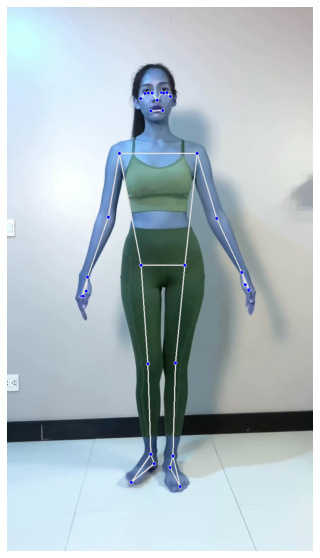

In [ ]:
from IPython.display import display,Image
path='/content/drive/MyDrive/Footage/filtered_frame/pookie/front/front.jpg'

mp_drawing = mp.solutions.drawing_utils
mp_pose=mp.solutions.pose

image=cv2.imread(path)

with mp_pose.Pose(min_detection_confidence=0.5,min_tracking_confidence=0.5) as pose:
  image=cv2.cvtColor(cv2.flip(image,1),cv2.COLOR_BGR2RGB)
  image.flags.writeable=False
  results=pose.process(image)
  image.flags.writeable=True
  image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
  mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_pose.POSE_CONNECTIONS)
  #print(results.pose_landmarks)
  plt.figure(figsize=(7,10))
  print(f"left {results.pose_landmarks.landmark[11]}|right {results.pose_landmarks.landmark[12]}")
  plt.imshow(image)
  plt.axis(False)


In [ ]:
from pathlib import Path
def save_frame(path,image,frame_name,frame_type):
  folder_name=Path(path).stem
  filepath='/content/drive/MyDrive/Footage/filtered_frame'
  full_path=Path(f"{filepath}/{folder_name}/{frame_type}")
  if not full_path.is_dir():
    full_path.mkdir(parents=True,exist_ok=True)
  cv2.imwrite(f"{full_path}/{frame_name}",image)


In [ ]:
from tqdm.auto import tqdm
path='/content/drive/MyDrive/Footage/pookie.mp4'

mp_drawing = mp.solutions.drawing_utils
mp_pose=mp.solutions.pose

cap=cv2.VideoCapture(path)
count_front_back=0
count_left_right=0
image_front=[]

value_front=0
image_side=[]
value_side=2

with mp_pose.Pose(min_detection_confidence=0.5,min_tracking_confidence=0.5) as pose:
  frame_length=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  for i in tqdm(range(frame_length)):  
    success,image=cap.read()
    if not success:
      continue
    orgimg=image
    image=cv2.cvtColor(cv2.flip(image,1),cv2.COLOR_BGR2RGB)
    image.flags.writeable=False
    results=pose.process(image)
    image.flags.writeable=True
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_pose.POSE_CONNECTIONS)

    left_height=results.pose_landmarks.landmark[27].y-results.pose_landmarks.landmark[11].y #height from shoulder to foot joint
    
    left_shoulder_x=results.pose_landmarks.landmark[11].x
    right_shoulder_x=results.pose_landmarks.landmark[12].x
    left_shoulder_visible=results.pose_landmarks.landmark[11].visibility
    right_shoulder_visible=results.pose_landmarks.landmark[12].visibility
    if left_shoulder_visible<0.5 or right_shoulder_visible <0.5:
      continue
    if(abs(left_shoulder_x-right_shoulder_x))>left_height/2.6:
      save_frame(path=path,image=orgimg,frame_name=f"frame{count_front_back}.jpg",frame_type="front_back")
      count_front_back+=1
      front_dis=abs(left_shoulder_x-right_shoulder_x)
      if value_front<front_dis:
        if results.pose_landmarks.landmark[11].x>results.pose_landmarks.landmark[12].x:
          value_front=front_dis
          image_front=orgimg
    else:
      save_frame(path=path,image=orgimg,frame_name=f"frame{count_left_right}.jpg",frame_type="left_right")
      count_left_right+=1
      side_dis=abs(left_shoulder_x-right_shoulder_x)
      if value_side>side_dis:
        value_side=side_dis
        image_side=orgimg
if value_front!=0:
  save_frame(path=path,image=image_front,frame_name=f"front.jpg",frame_type="front")
if value_side!=2:
  save_frame(path=path,image=image_side,frame_name=f"side.jpg",frame_type="side")


  0%|          | 0/907 [00:00<?, ?it/s]